# Miscellaneous COVID-19 Data Analyses using CDC Data

Data source:

- <a target="_blank" href="https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm">CDC Provisional Death Counts for Coronavirus Disease</a>

The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19](https://github.com/bmc/covid19/).


In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from dataclasses import dataclass
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2


In [2]:
CDC_DATA_PATH = 'data/cdc/Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)

## Preload the data we need

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


In [5]:
@dataclass
class CDCDataRow:
    start_week: date
    state: str        # 'United States' for a sum up
    deaths: int

In [6]:
# Load the data.

def load_data():
    cdc_data = dict()
    with open(CDC_DATA_PATH, mode='r', encoding='UTF_8') as f:
        c = csv.DictReader(f)
        for row in c:
            if row['Group'].lower() != 'by week':
                continue
            d = datetime.strptime(row['Start week'], '%m/%d/%Y')
            week = datetime.date(d)
            covid_19_deaths = csv_int_field(row, 'COVID-19 Deaths')
            state = row['State']
            datum = CDCDataRow(start_week=week, deaths=covid_19_deaths, state=state)
            state_data = cdc_data.get(state, dict())
            state_data[week] = datum
            cdc_data[state] = state_data
    return cdc_data

In [7]:
weekly_cdc_data = load_data()

In [8]:
def get_death_counts(weekly_data, state='United States', trim_final_week=True):
    """
    Extract weekly death counts for a particular state or
    for the United States as a whole.
    
    Returns a list of (datetime.date, count) pairs, which the date
    represents the start of a particular week.
    
    NOTE: The final week of the CDC data is automatically trimmed
    (unless trim_final_week is set to False), because experience
    shows that it generally represents partial data, which skews the
    graphs.
    """
    state_data = weekly_data[state]
    deaths = sorted([(week, datum.deaths) for week, datum in state_data.items()])

    if trim_final_week:
        deaths = deaths[:-1]

    return deaths

In [9]:
def plot_deaths(deaths, ylabel, image_file_name=None):
    """
    Given a list of (datetime.date, count) pairs, plot them.
    ylabel is the label to be affixed to the Y axis. The X axis
    label is fixed.
    
    The plot will show two lines: total deaths as of a particular
    week (accumulated), and deaths each week.
    """
    deaths_per_week = [d[1] for d in deaths]
    weeks = [datestr(d[0]) for d in deaths]

    fig, ax = p.subplots(figsize=(18, 14))

    # Plot deaths per week.
    ax.plot(weeks, deaths_per_week, markersize=10, color='red', marker='.', label='Deaths per week')
    #annotate_plot(weeks, deaths_per_week, ax)

    # generate weekly sums
    sums = [0 for i in weeks]
    accum = 0
    for i, d in enumerate(deaths_per_week):
        accum += d
        sums[i] = accum

    # Plot the sums
    ax.plot(weeks, sums, markersize=10, color='blue', marker='.', label='Total deaths')
    #annotate_plot(weeks, sums, ax)

    #total_deaths = sum([count for _, count in us_deaths])
    total_deaths = sums[-1]
    textbox(ax, 0.40, 0.90, f"Total deaths in period: {total_deaths:,}\nSource: CDC")

    ax.set_xlabel('Week Ending')
    ax.set_ylabel(ylabel)
    ax.legend()
    
    if image_file_name is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file_name))

    return (fig, ax)


## Plots

### US-wide deaths per week

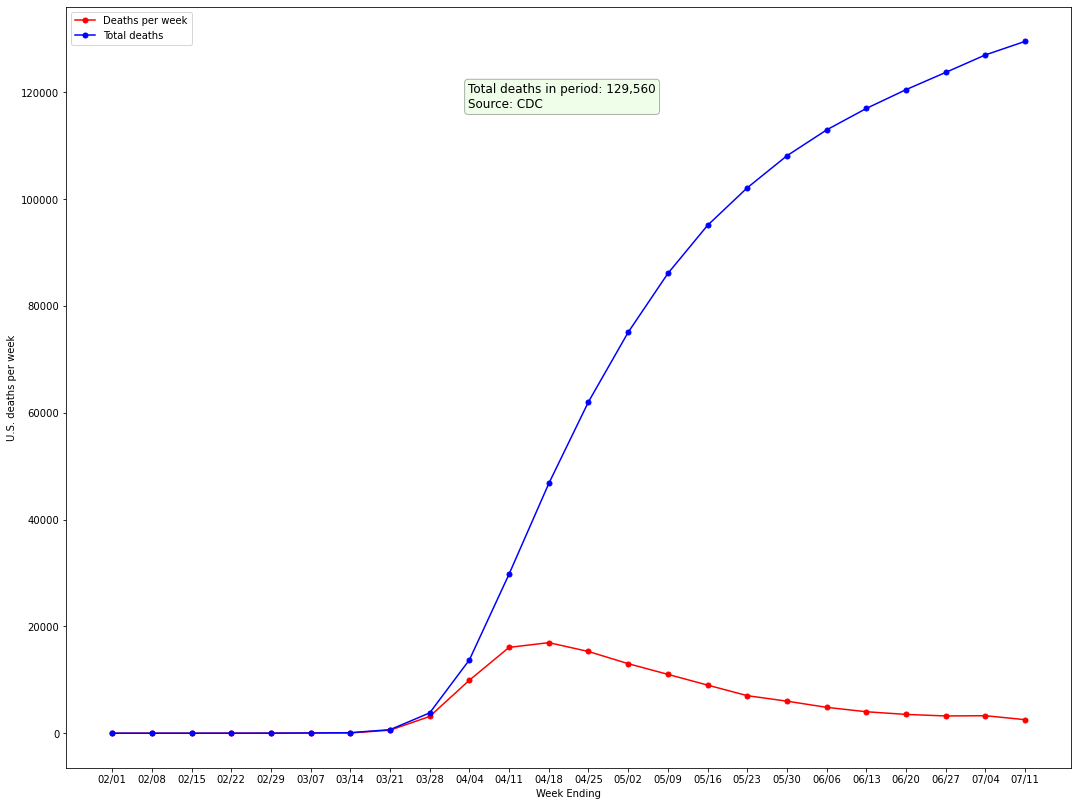

In [10]:
us_deaths = get_death_counts(weekly_cdc_data)
fig, ax = plot_deaths(us_deaths, 'U.S. deaths per week', image_file_name='cdc-us-deaths.png')
fig.show()

### Deaths per week, for a number of states

In [11]:
def plot_states(states, image_file=None, per_n=1):
    assert len(states) <= len(LINE_COLORS_AND_STYLES)
    fig, ax = p.subplots(figsize=(20, 12))
    
    data = [(get_death_counts(weekly_cdc_data, state), state, color, line_style)
            for state, (color, line_style) in zip(states, LINE_COLORS_AND_STYLES)]

    max_deaths = 0
    for stats, state, color, line_style in data:
        pop = populations[state]
        if per_n == 1:
            deaths_per_week = [count for _, count in stats]
        else:
            deaths_per_week = [get_per_capita_int(count, pop, per_n) for _, count in stats]

        max_deaths = max(max(deaths_per_week), max_deaths)
        weeks = [datestr(date) for date, _ in stats]

        # Plot deaths per week.
        ax.plot(weeks, deaths_per_week, color=color, marker='.', linestyle=line_style,
               label=f'{state} deaths per week')

    ymax, stride = determine_ymax_and_stride(max_deaths)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.legend()
    ax.set_ylabel(f"Deaths{'' if per_n == 1 else f' per {per_n:,}'}")

    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return (ax, fig)

#### Some of the bigger-hit states early in the pandemic

- California
- Connecticut
- Illinois
- Massachusetts
- New York
- Ohio
- Pennsylvania
- Washington

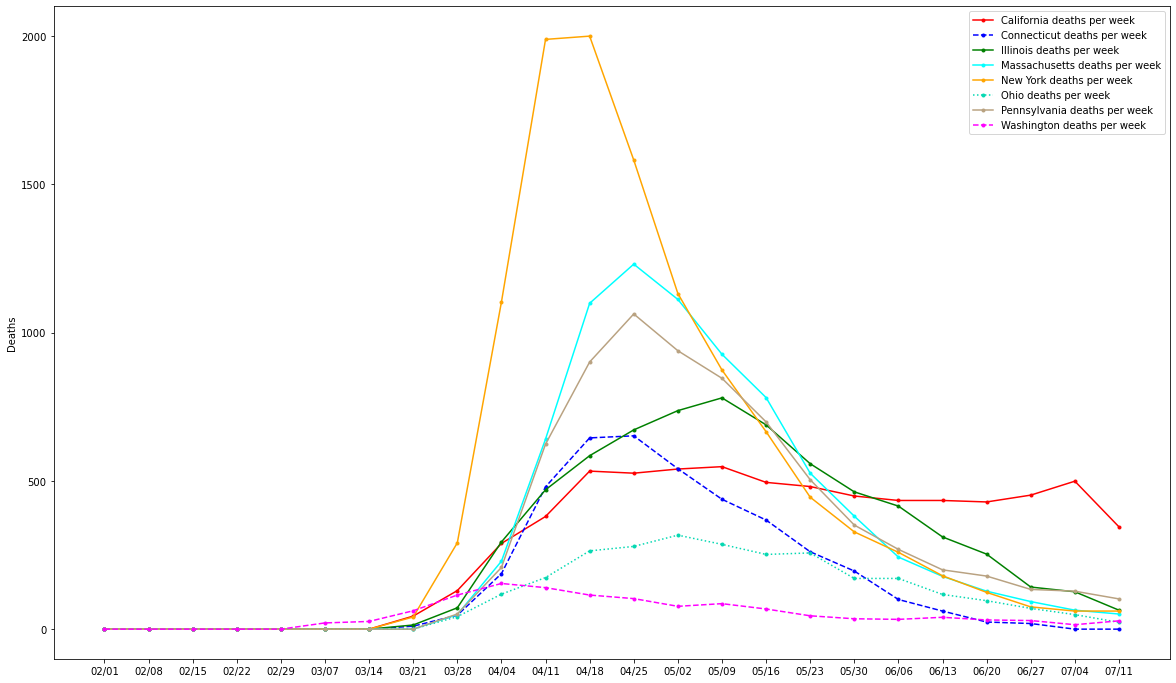

In [12]:
early_hit_states = ('California', 'Connecticut', 'Illinois', 'Massachusetts',
                    'New York', 'Ohio', 'Pennsylvania', 'Washington')
plot_states(early_hit_states, 'cdc-state-comparisons-early-2020.png');

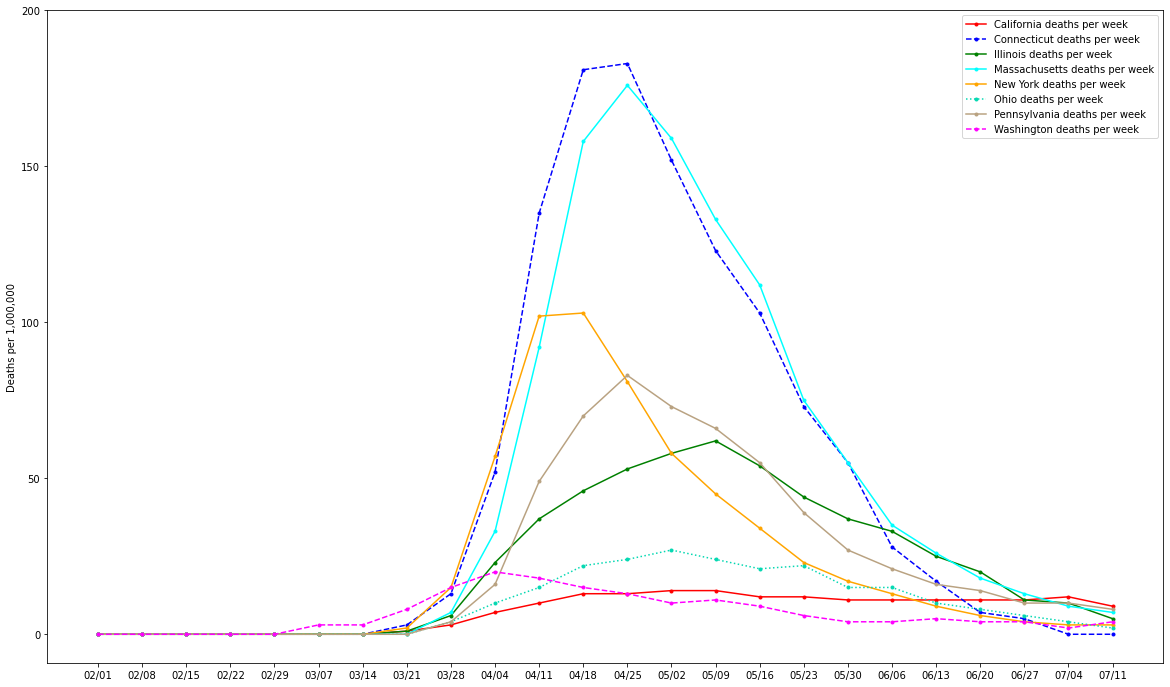

In [13]:
plot_states(early_hit_states, 'cdc-state-comparisons-early-2020-per-million.png', per_n=1_000_000);

#### Some of the bigger-hit states after the hurried reopenings

- California
- Arizona
- Texas
- Florida
- Oklahoma
- South Carolina

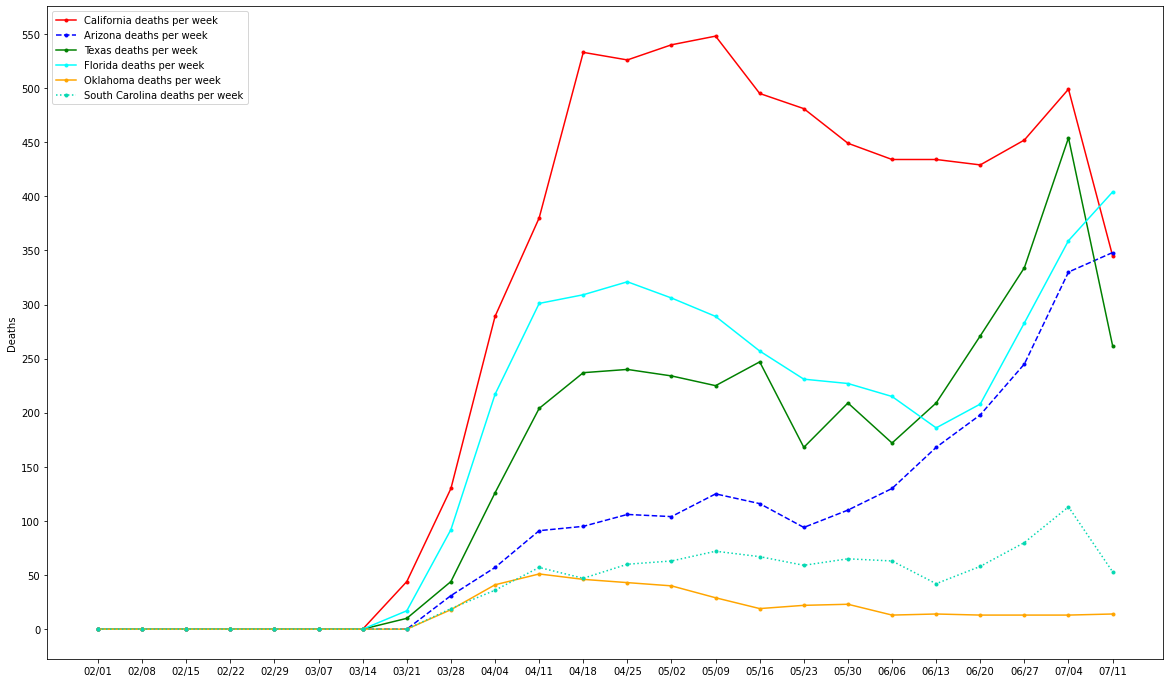

In [14]:
mid_2020_hit_states = ('California', 'Arizona', 'Texas', 'Florida', 'Oklahoma', 'South Carolina')
plot_states(mid_2020_hit_states, 'cdc-state-comparisons-mid-2020.png');

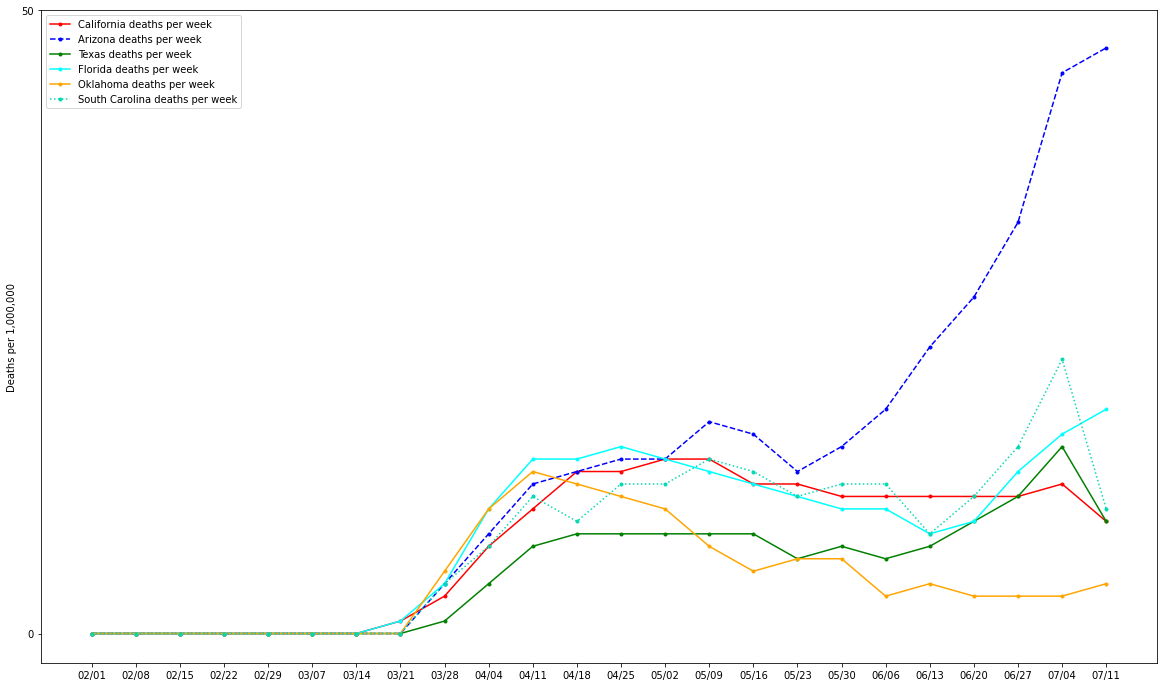

In [15]:
plot_states(mid_2020_hit_states, 'cdc-state-comparisons-mid-2020.png', per_n=1_000_000);